In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
class SelfAttention(layers.Layer):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.query = layers.Conv2D(embed_dim, kernel_size=1)
        self.key   = layers.Conv2D(embed_dim, kernel_size=1)
        self.value = layers.Conv2D(embed_dim, kernel_size=1)
        self.softmax = layers.Softmax(axis=-1)

    def call(self, x):
        B, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        q = tf.reshape(self.query(x), [B, H*W, C])
        k = tf.reshape(self.key(x), [B, H*W, C])
        v = tf.reshape(self.value(x), [B, H*W, C])

        attn_scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(tf.cast(C, tf.float32))
        attn_map = self.softmax(attn_scores)
        out = tf.matmul(attn_map, v)
        out = tf.reshape(out, [B, H, W, C])
        return out + x   # residual connection

In [ ]:
def build_cnn_attention_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    # Attention block
    x = SelfAttention(embed_dim=64)(x)
    x = layers.BatchNormalization()(x)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
model = build_cnn_attention_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 8, 8, 64)       │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,298 (344.91 KB)

 Trainable params: 87,978 (343.66 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    x_train, y_train, validation_split=0.1,
    epochs=20,
    batch_size=64,
    validation_data=(x_test, y_test)
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.3684 - loss: 1.6986 - val_accuracy: 0.3339 - val_loss: 2.0120
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5811 - loss: 1.1618 - val_accuracy: 0.6167 - val_loss: 1.0465
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6322 - loss: 1.0242 - val_accuracy: 0.6560 - val_loss: 0.9399
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6659 - loss: 0.9418 - val_accuracy: 0.6164 - val_loss: 1.0796
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6874 - loss: 0.8867 - val_accuracy: 0.7059 - val_loss: 0.8268
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7031 - loss: 0.8434 - val_accuracy: 0.7018 - val_loss: 0.8590
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7183 - loss: 0.8072 - val_accuracy: 0.6198 - val_loss: 1.1159
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7285 - loss: 0.7677 - val_accuracy:

In [ ]:
history_continued = model.fit(
    x_train, y_train, validation_split=0.1,
    epochs=40, # Total epochs
    initial_epoch=20, # Start from epoch 20 (already completed)
    batch_size=64,
    validation_data=(x_test, y_test)
)

Epoch 21/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8300 - loss: 0.4942 - val_accuracy: 0.8169 - val_loss: 0.5322
Epoch 22/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8299 - loss: 0.4889 - val_accuracy: 0.8056 - val_loss: 0.5833
Epoch 23/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8306 - loss: 0.4904 - val_accuracy: 0.8111 - val_loss: 0.5675
Epoch 24/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8307 - loss: 0.4858 - val_accuracy: 0.8056 - val_loss: 0.5786
Epoch 25/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8290 - loss: 0.4900 - val_accuracy: 0.8167 - val_loss: 0.5295
Epoch 26/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8276 - loss: 0.4864 - val_accuracy: 0.8316 - val_loss: 0.4972
Epoch 27/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8343 - loss: 0.4787 - val_accuracy: 0.8213 - val_loss: 0.5435
Epoch 28/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8384 - loss: 0.4747 - val_acc

Now, let's visualize the attention for the first image in the test set (index 0).

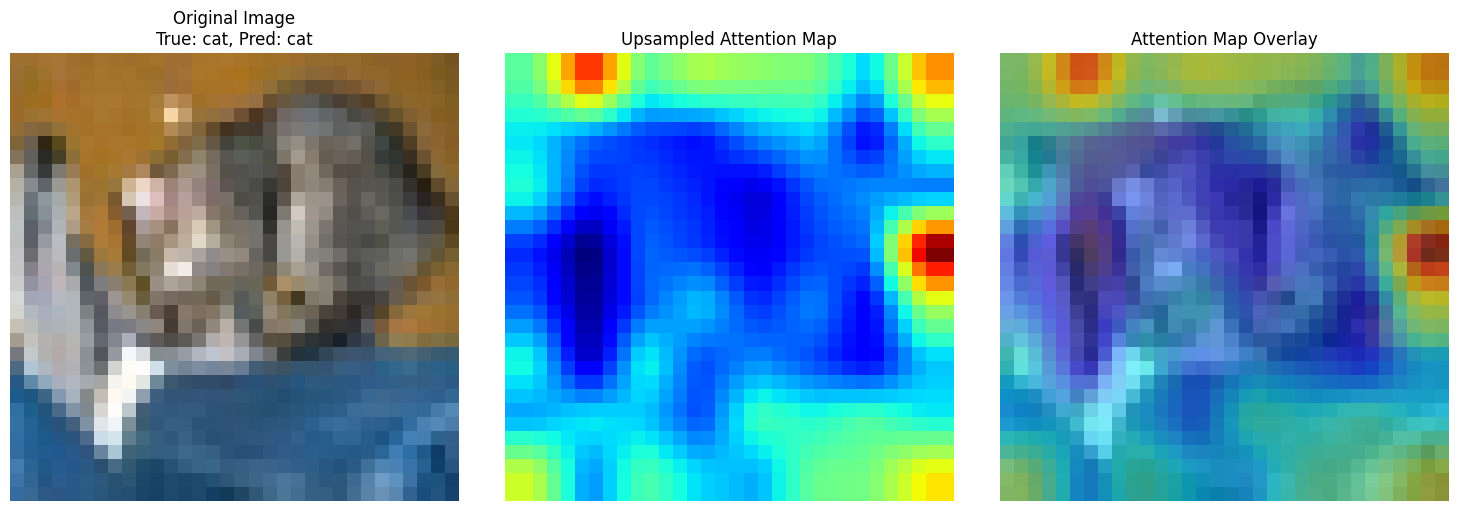

In [ ]:
visualize_attention(0)

You can change the index passed to `visualize_attention()` to see the attention map for other images in the test set.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest accuracy: {test_acc*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8205 - loss: 0.5464

Test accuracy: 82.29%


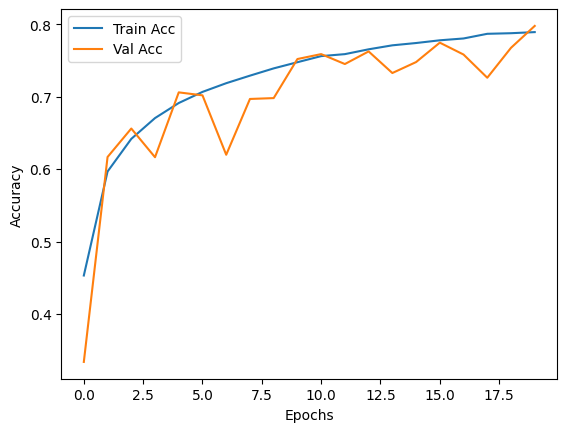

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/XAI/cifar10_attention_model.h5')

In [ ]:
model.save('/content/drive/MyDrive/XAI/cifar10_attention_model.keras')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


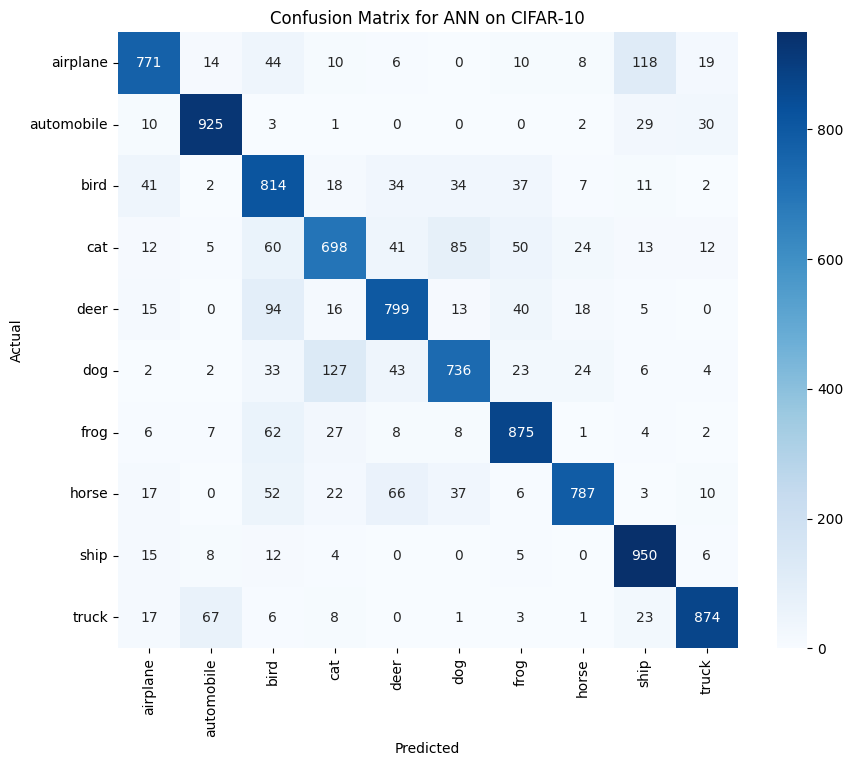


Classification Report:

              precision    recall  f1-score   support

    airplane       0.85      0.77      0.81      1000
  automobile       0.90      0.93      0.91      1000
        bird       0.69      0.81      0.75      1000
         cat       0.75      0.70      0.72      1000
        deer       0.80      0.80      0.80      1000
         dog       0.81      0.74      0.77      1000
        frog       0.83      0.88      0.85      1000
       horse       0.90      0.79      0.84      1000
        ship       0.82      0.95      0.88      1000
       truck       0.91      0.87      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [ ]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten() # Corrected: y_test is already class labels, just flatten if needed for comparison

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for ANN on CIFAR-10')
plt.show()

# Optional: print detailed metrics
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

XAI

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

In [ ]:
attention_layer_name = None
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Layer) and "SelfAttention" in str(type(layer)):
        attention_layer_name = layer.name
        break

attention_model = Model(inputs=model.input,
                        outputs=model.get_layer(attention_layer_name).output)

In [ ]:
def visualize_attention(image_index):
    img = x_test[image_index]
    true_label_idx = y_test[image_index][0]
    true_label_name = class_names[true_label_idx]

    # Predict the class for the image using the full model
    img_input_full_model = np.expand_dims(img, axis=0)
    pred_probs = model.predict(img_input_full_model, verbose=0)
    pred_label_idx = np.argmax(pred_probs)
    pred_label_name = class_names[pred_label_idx]

    # Get attention output from the attention_model
    attn_output = attention_model.predict(img_input_full_model, verbose=0)

    # The output includes the attention-applied feature map, not the raw attention weights.
    # So we visualize activation intensity as a proxy for attention strength.
    attn_map_raw = np.mean(attn_output[0], axis=-1)  # mean over channels (e.g., 8x8)

    # Normalize the attention map
    attn_map_norm = (attn_map_raw - attn_map_raw.min()) / (attn_map_raw.max() - attn_map_raw.min() + 1e-8)

    # Upsample the attention map to the original image dimensions (32x32)
    # tf.image.resize expects a 4D tensor (batch, height, width, channels)
    attn_map_upsampled = tf.image.resize(
        tf.expand_dims(tf.expand_dims(attn_map_norm, axis=-1), axis=0),
        (32, 32)
    ).numpy()[0, :, :, 0] # Remove batch and channel dimensions

    # --- Plot the original image, upsampled attention map, and the overlay ---
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image\nTrue: {true_label_name}, Pred: {pred_label_name}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(attn_map_upsampled, cmap='jet')
    plt.title("Upsampled Attention Map")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(attn_map_upsampled, cmap='jet', alpha=0.5) # Overlay with transparency
    plt.title("Attention Map Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

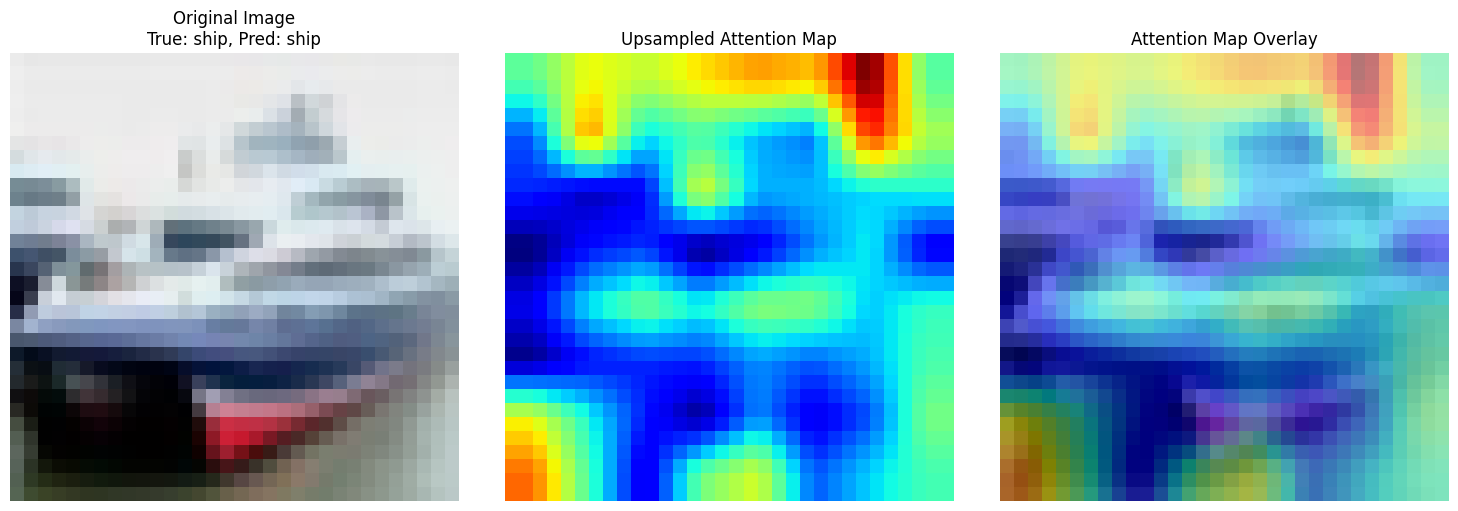

In [ ]:
visualize_attention(1)

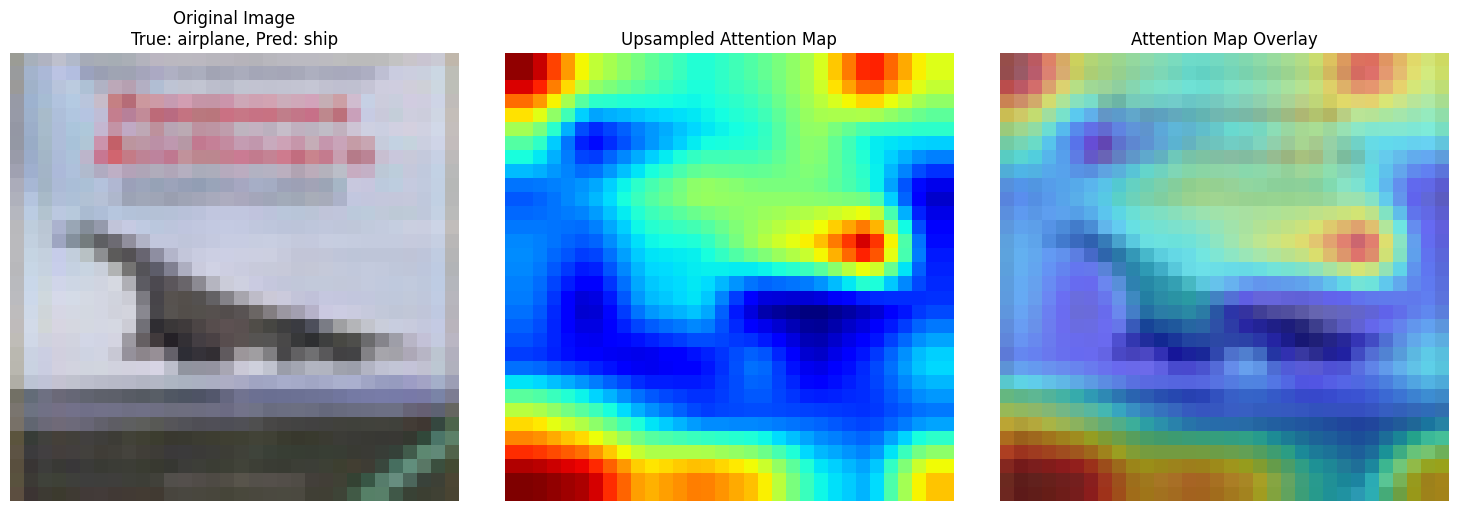

In [ ]:
visualize_attention(3)

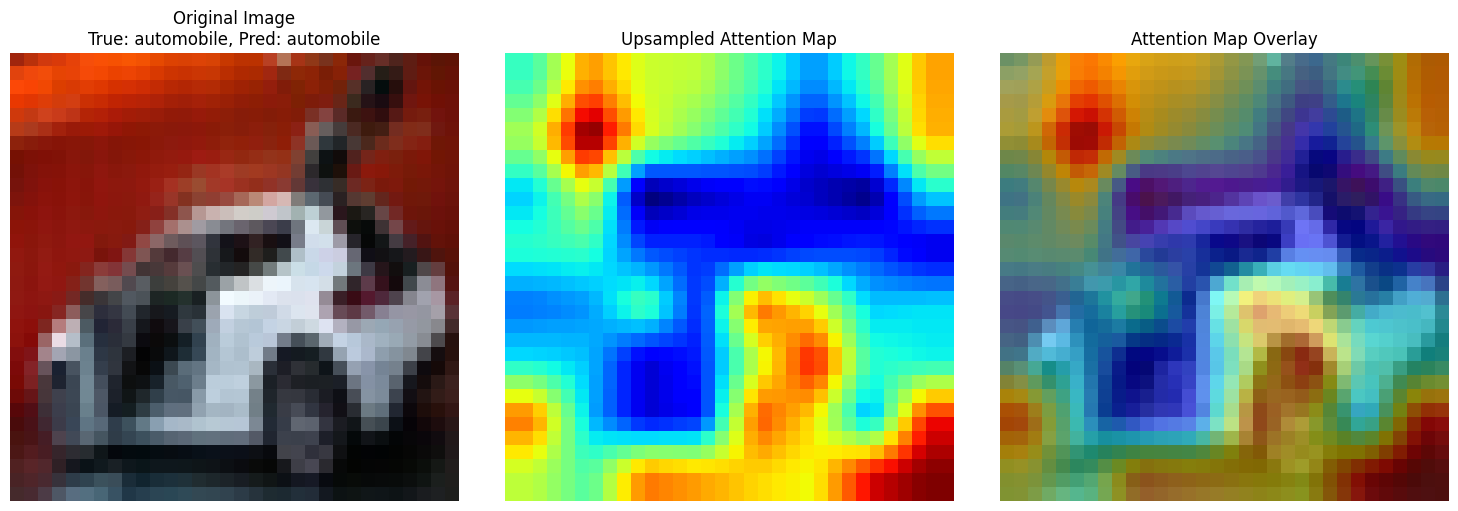

In [ ]:
visualize_attention(6)

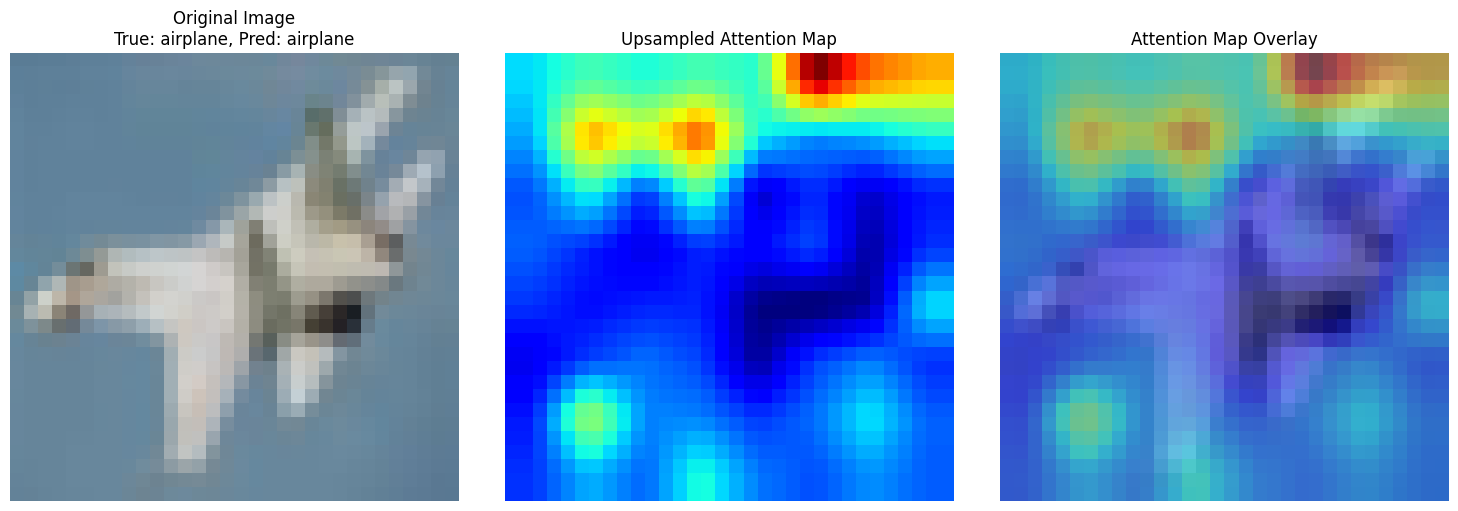

In [ ]:
visualize_attention(10)

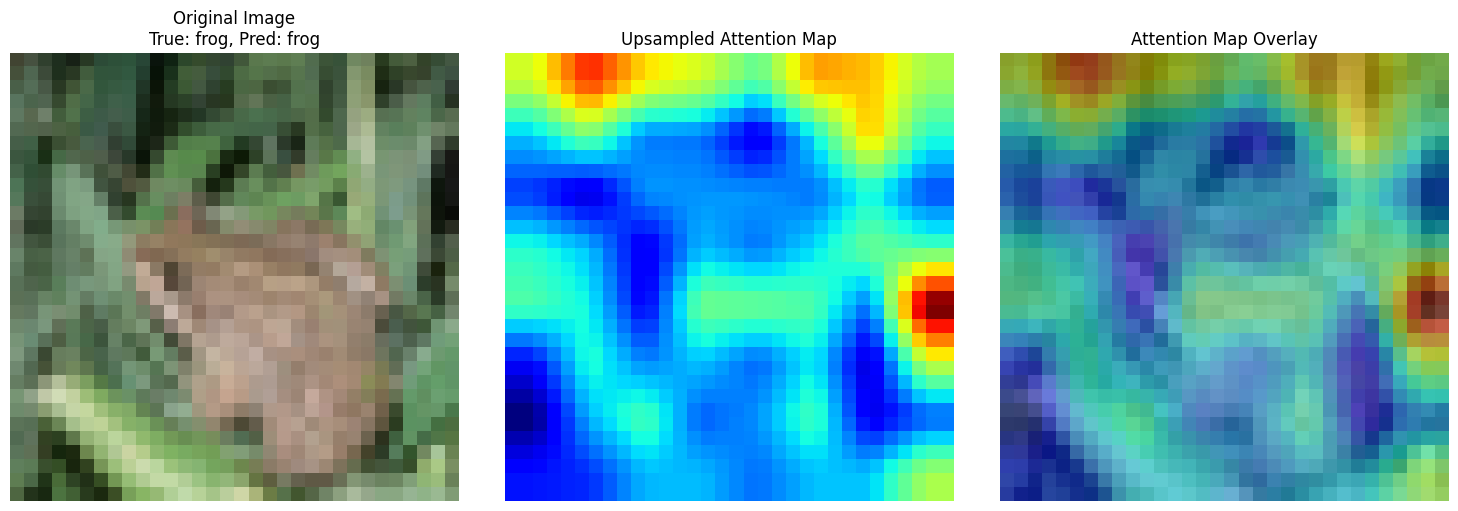

In [ ]:
visualize_attention(4)

Found attention layer: self_attention


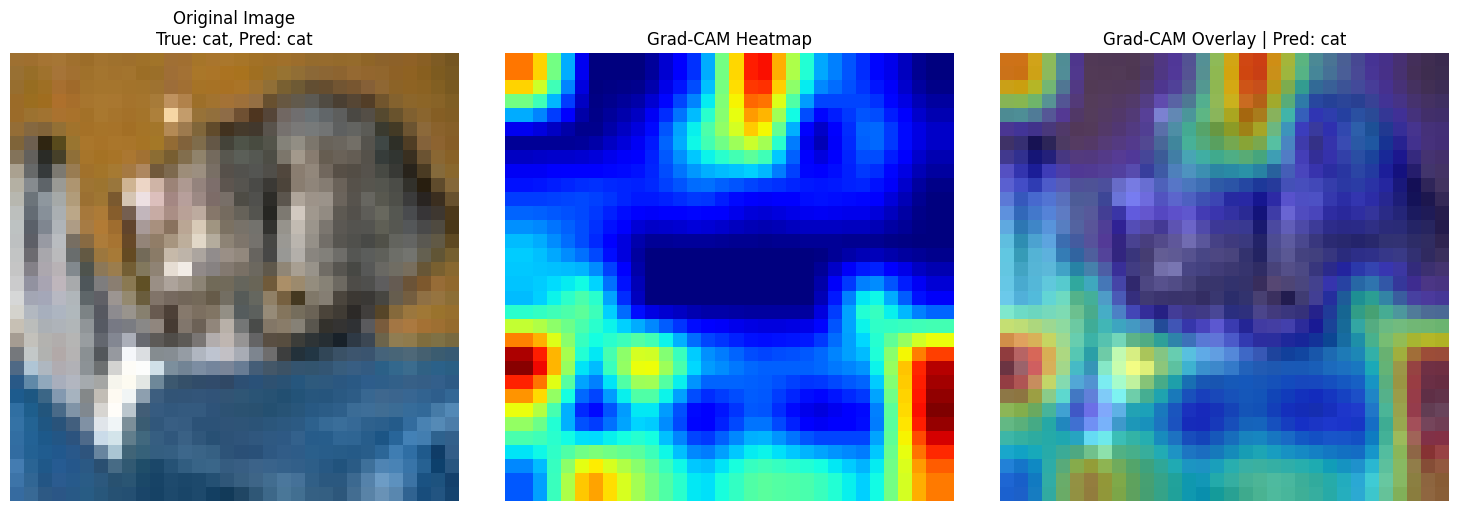

In [ ]:
def gradcam_on_attention(model, image_index, layer_name, class_index=None):
    """
    Compute Grad-CAM heatmap using the output of the attention layer
    and visualize it with the original image.
    """
    img = x_test[image_index]
    true_label_idx = y_test[image_index][0]
    true_label_name = class_names[true_label_idx]

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        inputs = tf.cast(tf.expand_dims(img, axis=0), tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8 # Normalize for visualization

    # Upsample the heatmap to the original image dimensions
    heatmap_upsampled = tf.image.resize(
        tf.expand_dims(tf.expand_dims(heatmap, axis=-1), axis=0),
        (32, 32)
    ).numpy()[0, :, :, 0] # Remove batch and channel dimensions

    # Predict the class for the image using the full model
    pred_probs = model.predict(inputs, verbose=0)
    pred_label_idx = np.argmax(pred_probs)
    pred_label_name = class_names[pred_label_idx]

    # --- Plot the original image, heatmap, and the overlay ---
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image\nTrue: {true_label_name}, Pred: {pred_label_name}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_upsampled, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(heatmap_upsampled, cmap='jet', alpha=0.5) # Overlay with transparency
    plt.title(f"Grad-CAM Overlay | Pred: {pred_label_name}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return heatmap_upsampled, pred_label_idx

# ---- Find the SelfAttention layer name (assuming it's already defined) ----
attn_layer = None
for layer in model.layers:
    if "SelfAttention" in str(type(layer)):
        attn_layer = layer.name
        break

if attn_layer:
    print(f"Found attention layer: {attn_layer}")
    # ---- Generate Grad-CAM heatmap and visualize for the first test image ----
    gradcam_heatmap, _ = gradcam_on_attention(model, 0, attn_layer) # Store the heatmap
else:
    print("No SelfAttention layer found in the model.")

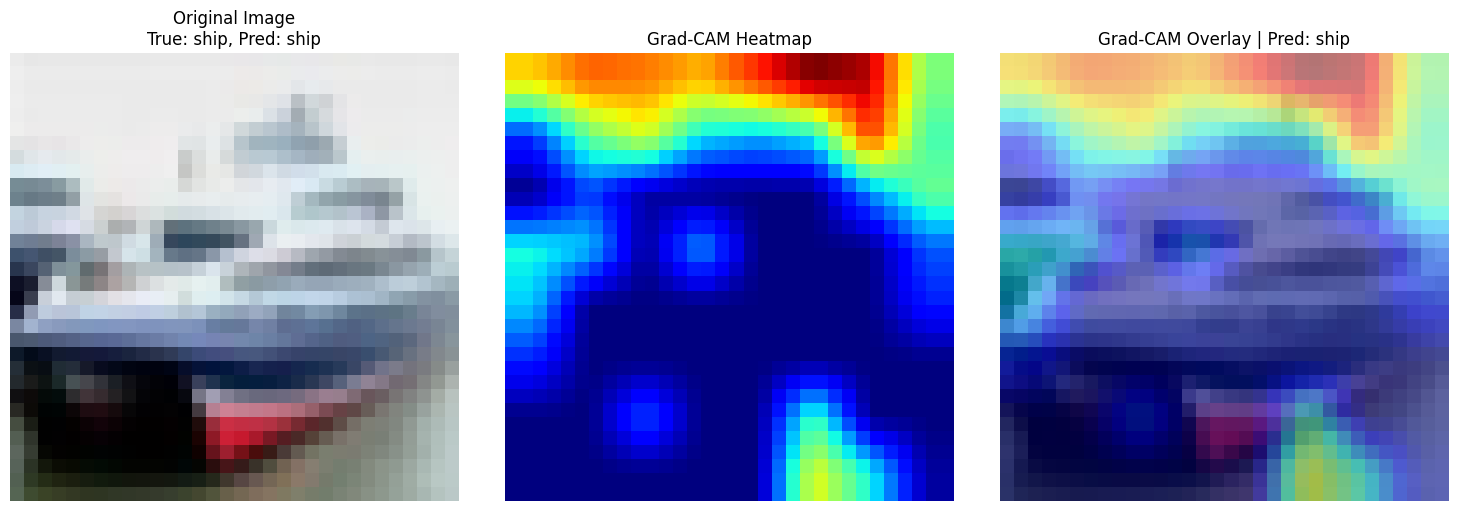

(array([[0.68031263, 0.68031263, 0.69539785, ..., 0.5559509 , 0.5000524 ,
         0.5000524 ],
        [0.68031263, 0.68031263, 0.69539785, ..., 0.5559509 , 0.5000524 ,
         0.5000524 ],
        [0.61626923, 0.61626923, 0.63418585, ..., 0.54715186, 0.49157423,
         0.49157423],
        ...,
        [0.        , 0.        , 0.        , ..., 0.06184314, 0.02397352,
         0.02397352],
        [0.        , 0.        , 0.        , ..., 0.07067788, 0.02739831,
         0.02739831],
        [0.        , 0.        , 0.        , ..., 0.07067788, 0.02739831,
         0.02739831]], dtype=float32),
 np.int64(8))

In [ ]:
gradcam_on_attention(model, 1, attention_layer_name)

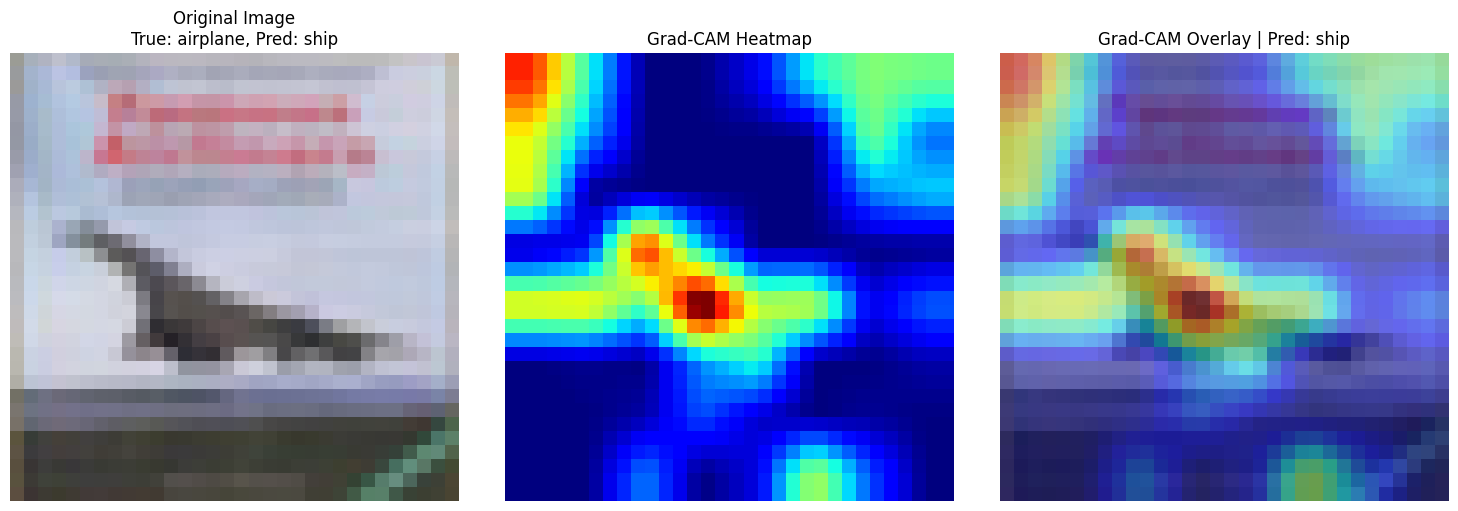

In [ ]:
gradcam_on_attention(model, 3, attention_layer_name)

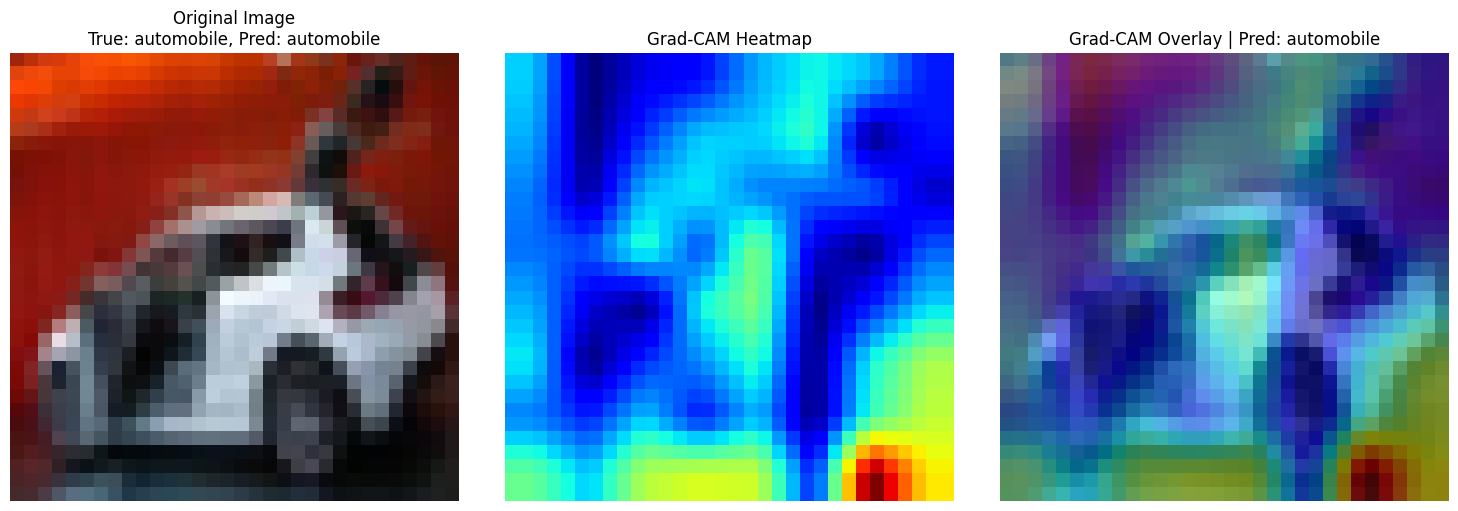

In [ ]:
gradcam_on_attention(model, 6, attention_layer_name)

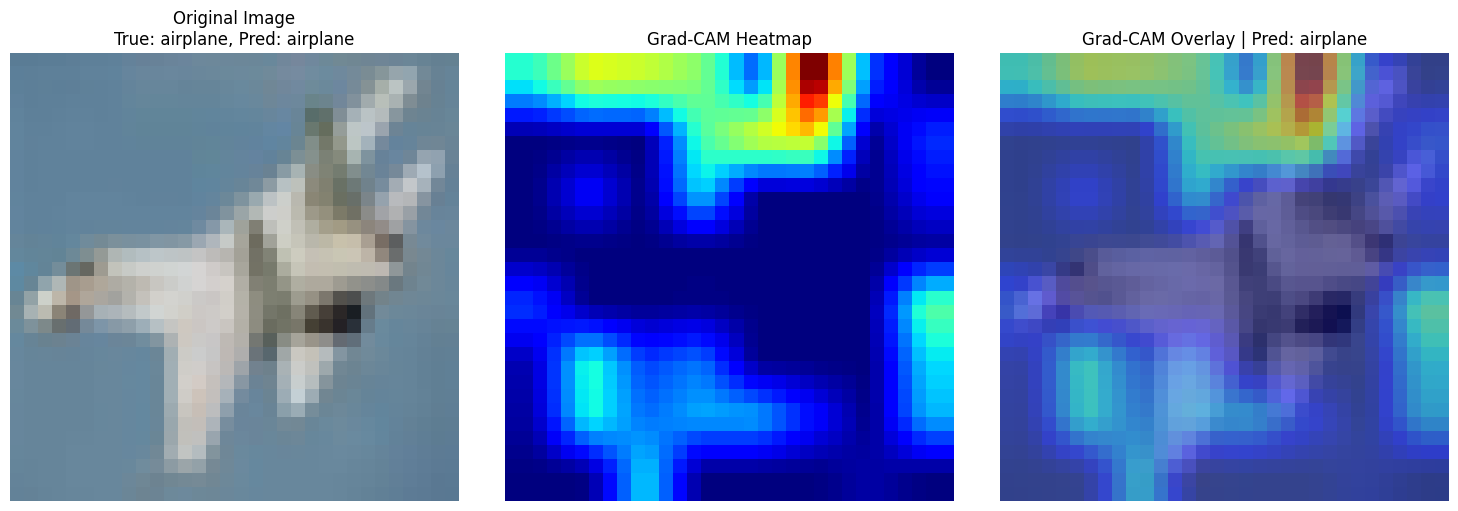

In [ ]:
gradcam_on_attention(model, 10, attention_layer_name)

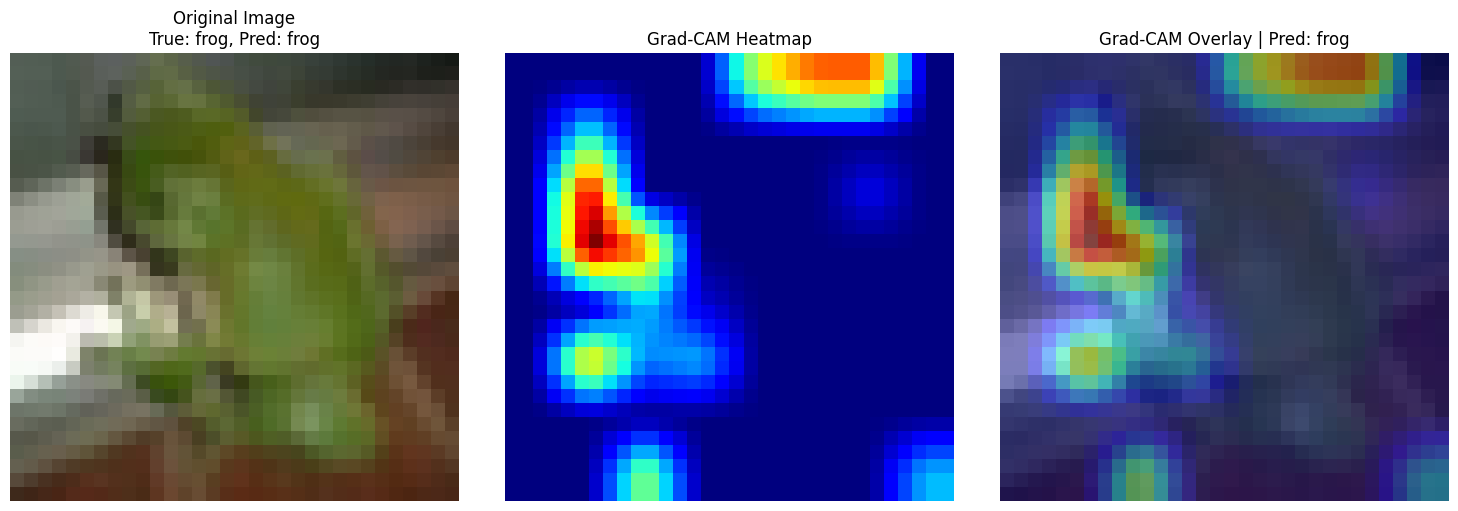

In [ ]:
gradcam_on_attention(model, 7, attention_layer_name)

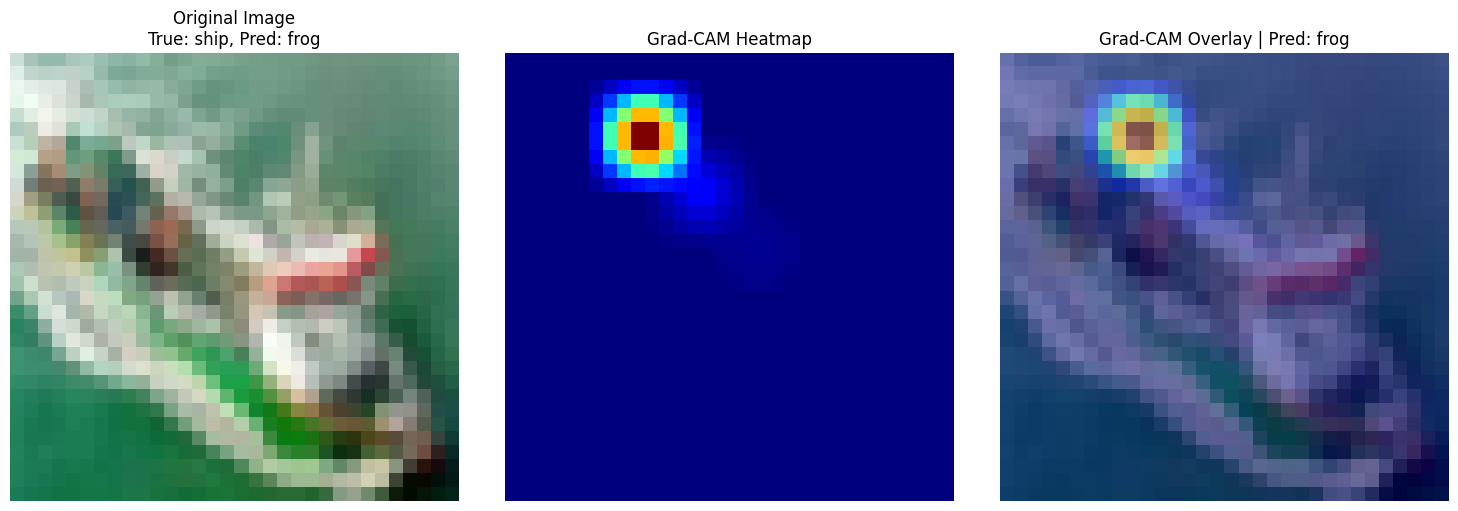

In [ ]:
gradcam_on_attention(model, 15, attention_layer_name)

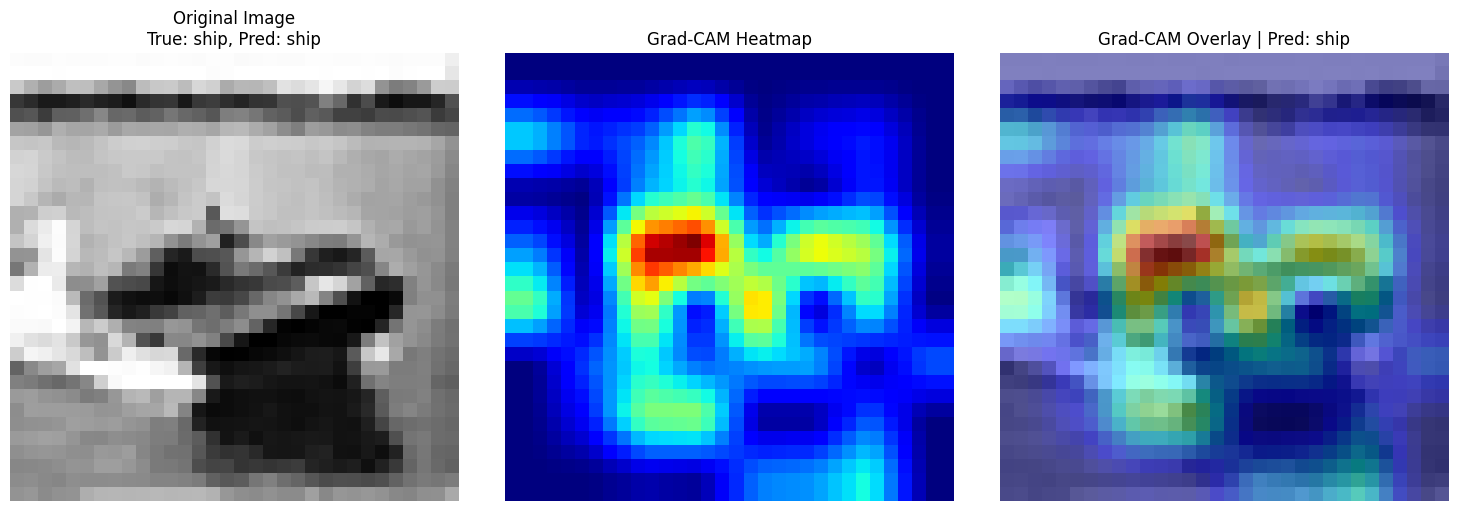

In [ ]:
gradcam_on_attention(model, 150, attention_layer_name)

The attention map tells you where their eyes moved.

The Grad-CAM map tells you which regions of the scene actually helped them make the decision.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def deletion_metric(model, image, heatmap, label, steps=20, baseline_val=0.5):
    # Normalize Grad-CAM heatmap to [0,1]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() + 1e-8

    # Flatten and sort pixel indices by importance (descending)
    h, w = heatmap.shape
    flat_idx = np.argsort(-heatmap.flatten())

    # Prepare baseline version (e.g., gray)
    baseline_img = np.ones_like(image) * baseline_val
    deleted_img = image.copy()

    preds = []
    pixels_per_step = (h * w) // steps

    for i in range(0, h*w, pixels_per_step):
        # Mask out top pixels gradually
        idx_to_delete = flat_idx[:i]
        mask = np.ones((h*w,), dtype=np.float32)
        mask[idx_to_delete] = 0
        mask = mask.reshape((h, w, 1))

        deleted_img = image * mask + baseline_img * (1 - mask)
        pred = model.predict(np.expand_dims(deleted_img, axis=0), verbose=0)[0][label]
        preds.append(pred)

    # Fraction of pixels removed
    fractions = np.linspace(0, 1, len(preds))

    plt.figure(figsize=(6,4))
    plt.plot(fractions, preds, marker='o')
    plt.title("Deletion Metric Curve")
    plt.xlabel("Fraction of pixels removed (high → low importance)")
    plt.ylabel("Model confidence for true class")
    plt.grid(True)
    plt.show()

    # AUC (lower = more faithful)
    auc = np.trapz(preds, fractions)
    print(f"AUC (lower is better): {auc:.4f}")
    return auc


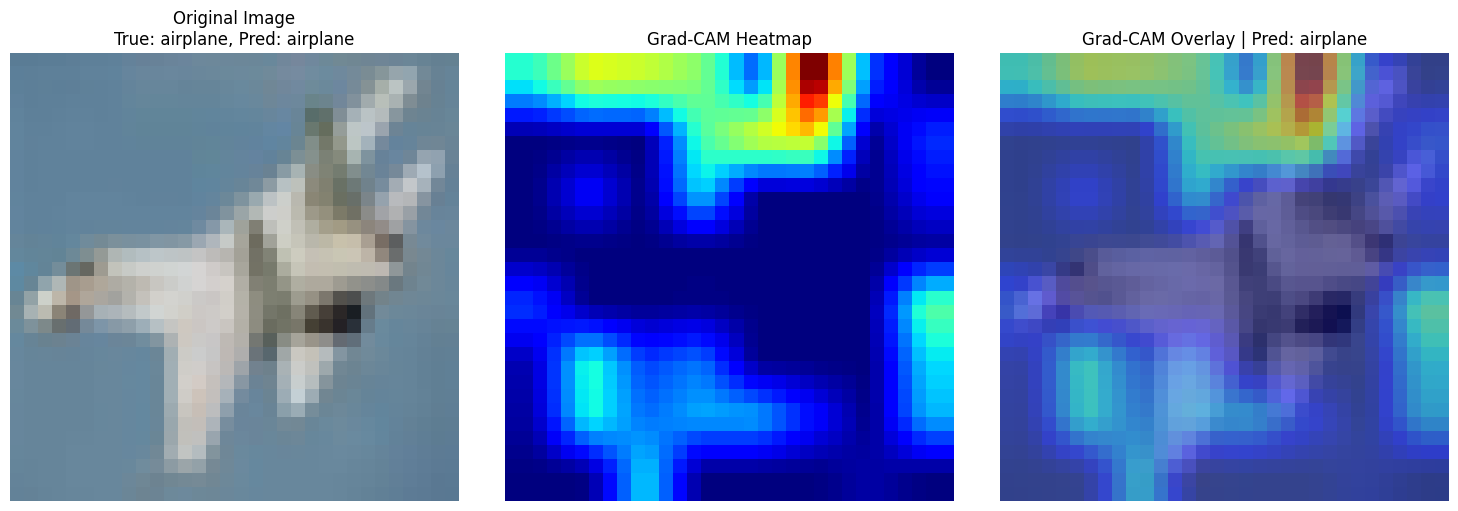

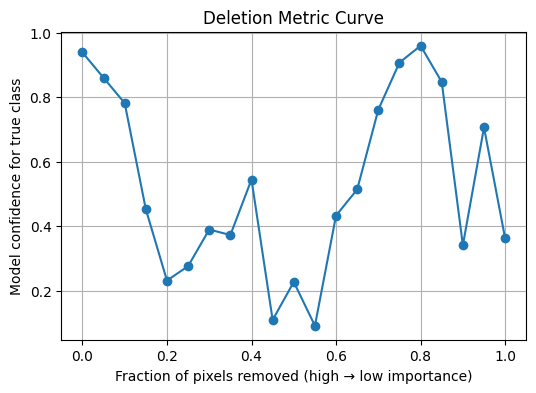

AUC (lower is better): 0.5233


/tmp/ipython-input-3808184130.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(preds, fractions)


np.float64(0.5232864551246166)

In [ ]:
sample_idx = 10
img = x_test[sample_idx]
true_label = y_test[sample_idx][0]  # Access the scalar label from y_test
gradcam_map, _ = gradcam_on_attention(model, sample_idx, attn_layer) # Call gradcam_on_attention to get the map

deletion_metric(model, img, gradcam_map, true_label)

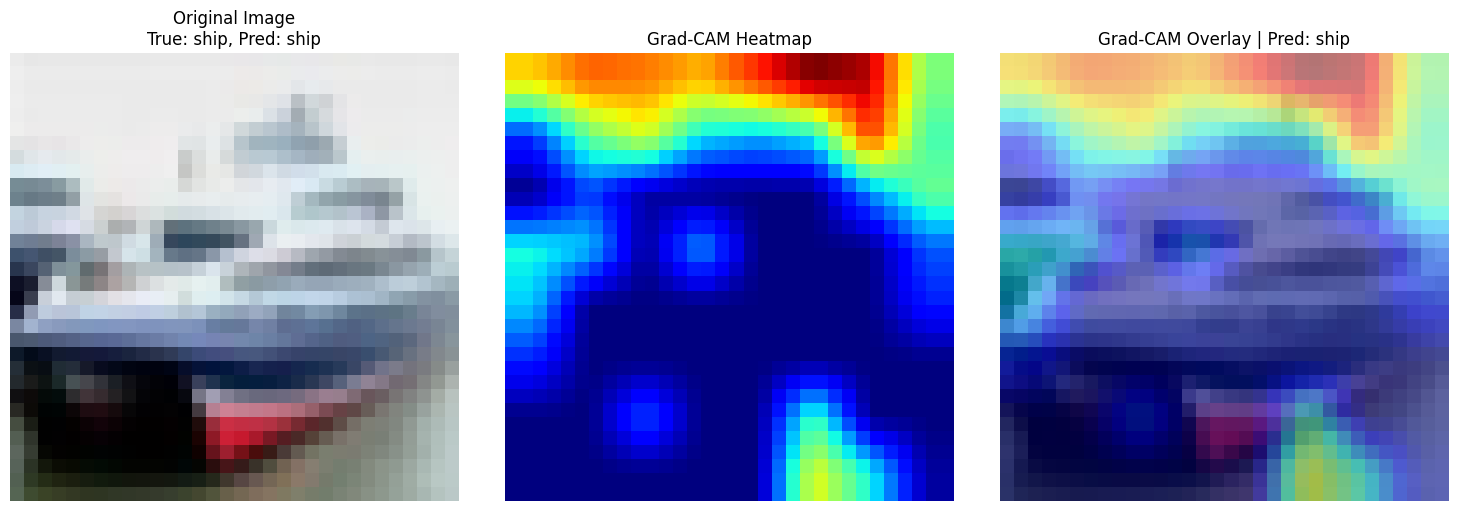

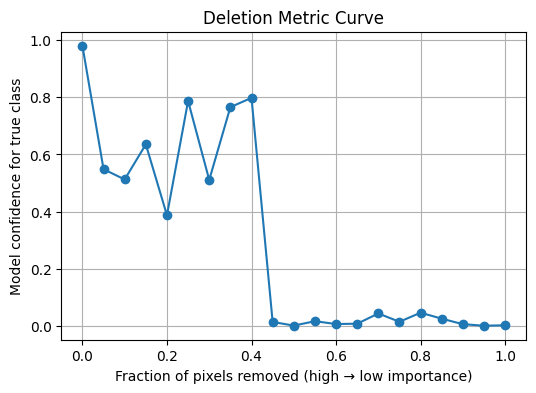

AUC (lower is better): 0.2807


/tmp/ipython-input-3808184130.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(preds, fractions)


np.float64(0.2807194744818844)

In [ ]:
sample_idx = 1
img = x_test[sample_idx]
true_label = y_test[sample_idx][0]
gradcam_map, _ = gradcam_on_attention(model, sample_idx, attn_layer)

deletion_metric(model, img, gradcam_map, true_label)

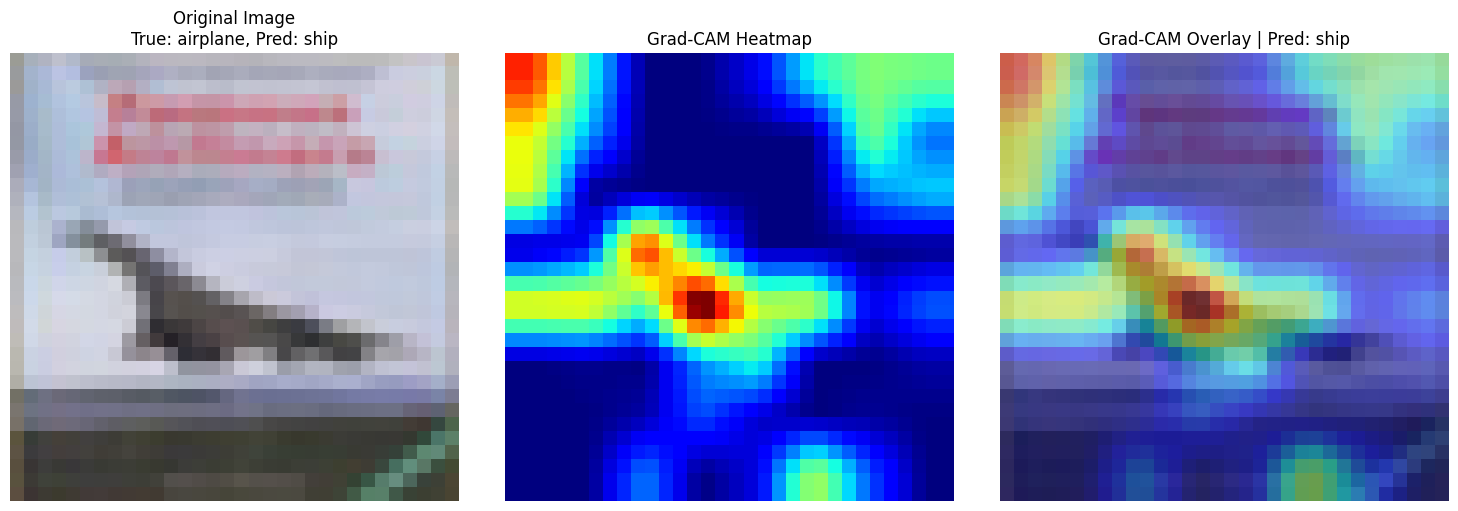

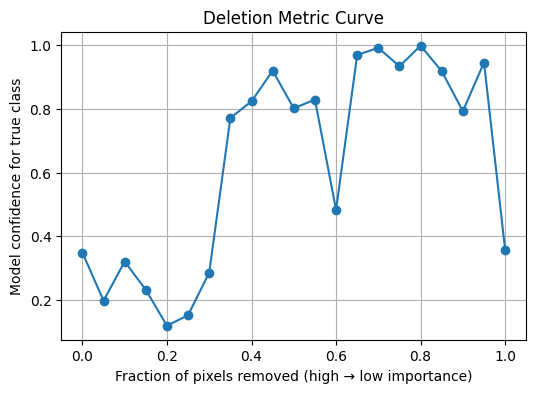

AUC (lower is better): 0.6421


/tmp/ipython-input-3808184130.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(preds, fractions)


np.float64(0.6421243190765381)

In [ ]:
sample_idx = 3
img = x_test[sample_idx]
true_label = y_test[sample_idx][0]
gradcam_map, _ = gradcam_on_attention(model, sample_idx, attn_layer) # Call gradcam_on_attention to get the map

deletion_metric(model, img, gradcam_map, true_label)

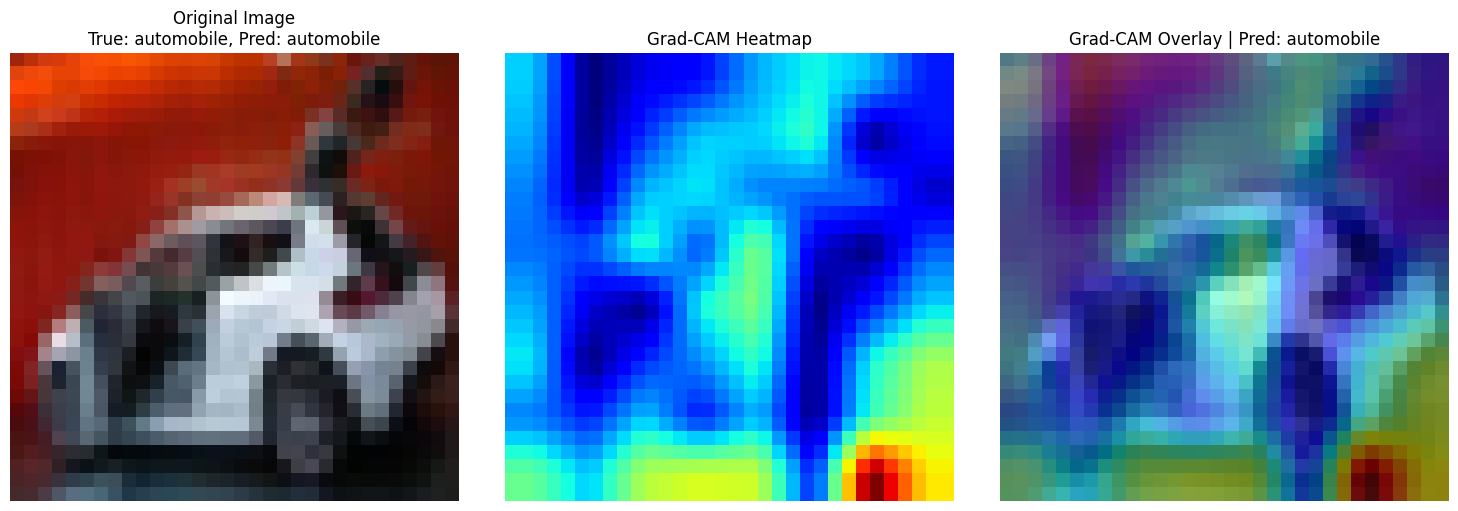

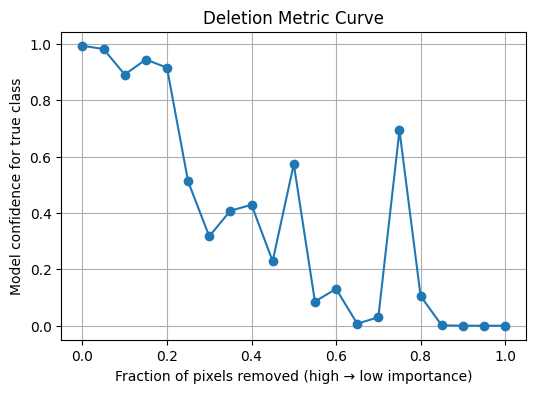

AUC (lower is better): 0.3876


/tmp/ipython-input-3808184130.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(preds, fractions)


np.float64(0.38756444788627964)

In [ ]:
sample_idx = 6
img = x_test[sample_idx]
true_label = y_test[sample_idx][0]
gradcam_map, _ = gradcam_on_attention(model, sample_idx, attn_layer) # Call gradcam_on_attention to get the map

deletion_metric(model, img, gradcam_map, true_label)

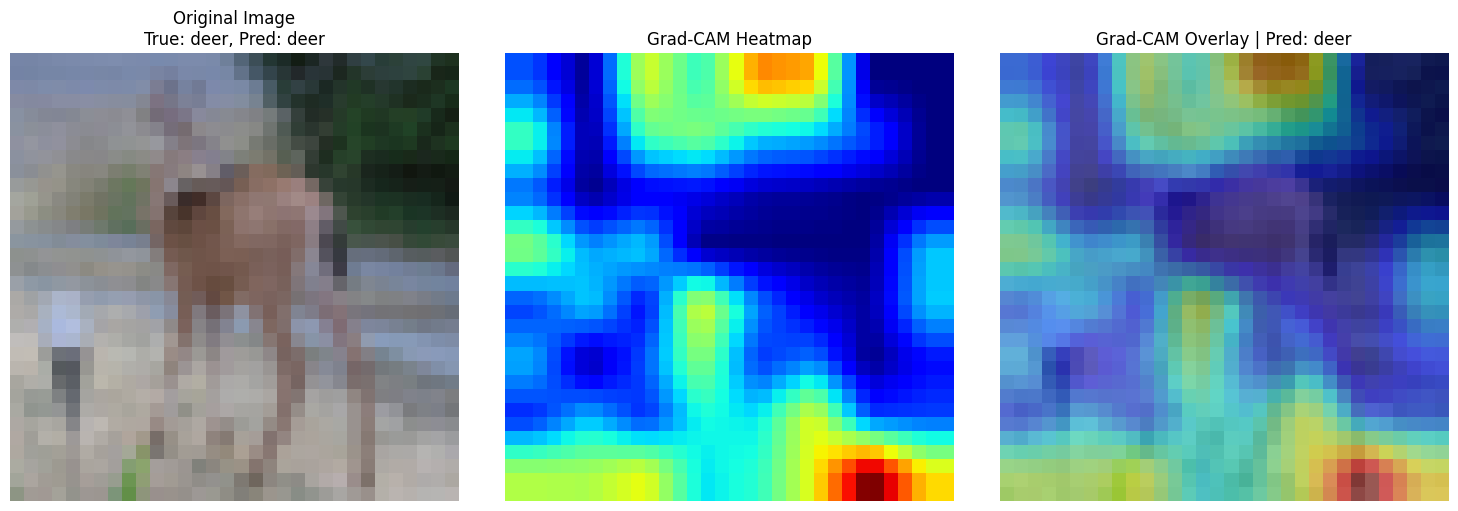

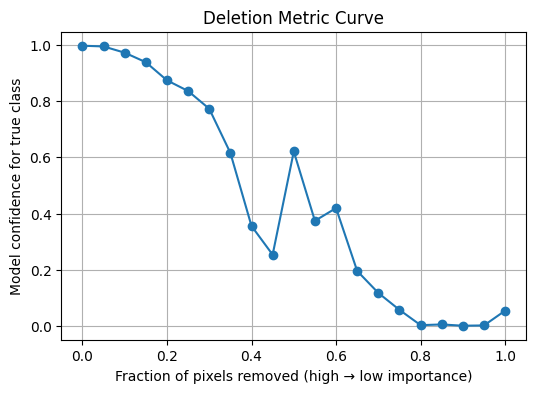

AUC (lower is better): 0.4470


/tmp/ipython-input-3808184130.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(preds, fractions)


np.float64(0.4469616992631927)

In [ ]:
sample_idx = 100
img = x_test[sample_idx]
true_label = y_test[sample_idx][0]
gradcam_map, _ = gradcam_on_attention(model, sample_idx, attn_layer) # Call gradcam_on_attention to get the map

deletion_metric(model, img, gradcam_map, true_label)